# Params

In [1]:
import os
import tensorflow as tf

SEED = 651987423
MODEL_NAME = 'Cellpose3D-Semanitc-Test'
IMG_SHAPE = (256,256,256,5) #Patching assumes IMG, and INPUT shape are cubic, d.h. H=W=D
INPUT_SHAPE = (64,64,64,5)
FEAT_CHANNELS = 16
FLOW_WEIGHT = 1
BG_WEIGHT = 1

os.makedirs(f'models/{MODEL_NAME}', exist_ok = True)

N_VAL, N_TEST = 1000, 5000
BATCH_SIZE = 16 # used batch size 64 for Cellpose3D
INITIAL_EPOCH = 0
INITIAL_LR = 0.001
N_EPOCHS = 100
N_PER_EPOCH = 1600 // BATCH_SIZE

OPT = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR)
# TODO METRICS, LRSchedule, DATA AUGMENT

# Load Data

In [2]:
import numpy as np

class Patch_Iterator():
    def __init__(self, img_shape, input_shape, n_val, n_test):
        samples = self.cartesian_product(np.arange(img_shape[0]-input_shape[0]), np.arange(img_shape[1]-input_shape[1]), np.arange(img_shape[2]-input_shape[2]))
        np.random.shuffle(samples)
        
        self.train, self.val, self.test = samples[n_test+n_val:], samples[n_test:n_test+n_val], samples[:n_test]
        self.n_train, self.n_val, self.n_test = len(self.train), n_val, n_test
        self.next_train, self.next_val, self.next_test = 0,0,0
        
    def cartesian_product(self, *arrays):
        la = len(arrays)
        dtype = np.result_type(*arrays)
        arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
        for i, a in enumerate(np.ix_(*arrays)):
            arr[...,i] = a
        return arr.reshape(-1, la)
    
    def get_next(self, dataset='train'):
        if dataset=='test':
            res = self.test[self.next_test] 
            self.next_test = (self.next_test + 1) % self.n_test
            return res
        elif dataset=='val':
            res = self.val[self.next_val] 
            self.next_val = (self.next_val + 1) % self.n_val
            return res
        else:
            res = self.train[self.next_train]
            self.next_train = (self.next_train + 1) % self.n_train
            return res

In [4]:
import tensorflow as tf 
import numpy as np
import glob
import os
import random

def load_data(path):
    fn = os.path.split(path)[-1]
    img = np.load(os.path.join('data', 'images', fn))
    mask = np.load(os.path.join('data', 'masks', fn))
    return img, mask

def get_patch(img, patch_shape, x_start, y_start, z_start):
    '''random tile strategy'''
    x_end = x_start + patch_shape[0]
    y_end = y_start + patch_shape[1]
    z_end = z_start + patch_shape[2]
    return img[x_start:x_end, y_start:y_end, z_start:z_end, :]

def create_patch_data(patch_shape, patch_iterator, dataset='train'):
    
    def patch_data(img, mask):
        x_start, y_start, z_start = patch_iterator.get_next(dataset=dataset)
        img = get_patch(img, patch_shape, x_start, y_start, z_start)
        mask = get_patch(mask, patch_shape, x_start, y_start, z_start)
        return img, mask
        
    return patch_data

def data_augment(img, mask):
    # TODO Implement, wichtig img, flow, mask sind tensoren
    # Original Paper: 'scale', 'noise', 'shuffle', 'inpaint', 'decline', 'variance_sampling', 'stretch', 'shrink', 'anisotropy' (Cellpose3D/dataloader/augmenter.py)
    return img, mask

def get_dataset(paths, patch_iterator, patch_size=64, dataset='train', augment=False):
    AUTOTUNE = tf.data.experimental.AUTOTUNE 
    
    imgs = np.zeros((len(paths),*IMG_SHAPE), dtype=np.float32) # for Cellpose-3D (without semantic mask of rachel) shape has to be 256,256,256,1
    masks = np.zeros((len(paths),256,256,256,4), dtype=np.float32)
    for idx, path in enumerate(paths):
        img, mask = load_data(path)
        imgs[idx], masks[idx] = img, mask
    ds = tf.data.Dataset.from_tensor_slices((imgs, masks))
    ds = ds.repeat()
    
    pd_func = create_patch_data(INPUT_SHAPE, patch_iterator, dataset=dataset)
    ds = ds.map(pd_func, num_parallel_calls=AUTOTUNE)

    if augment:
        ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
    if dataset == 'train':
        ds = ds.shuffle(1000)
    
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds


paths = sorted(glob.glob(os.path.join('data/images', '*.npy')))
patch_iterator = Patch_Iterator(IMG_SHAPE, INPUT_SHAPE, N_VAL, N_TEST)

patch_iterator = Patch_Iterator(IMG_SHAPE, INPUT_SHAPE, N_VAL, N_TEST)
train_ds = get_dataset(paths, patch_iterator, patch_size=INPUT_SHAPE[0], dataset='train', augment=True)
val_ds = get_dataset(paths, patch_iterator, patch_size=INPUT_SHAPE[0], dataset='val', augment=False)
test_ds = get_dataset(paths, patch_iterator, patch_size=INPUT_SHAPE[0], dataset='test', augment=False)

2022-06-07 16:49:23.842527: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 16:49:24.520975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43680 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2022-06-07 16:49:24.521617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43680 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:a1:00.0, compute capability: 8.6


2022-06-07 16:50:47.940816: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 64, 64, 64, 5) (32, 64, 64, 64, 4)
Value Range for FG_Mask: (sigmoid) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Value range for flow_mask: (tanh) tf.Tensor(-0.99999094, shape=(), dtype=float32) tf.Tensor(0.9999917, shape=(), dtype=float32)


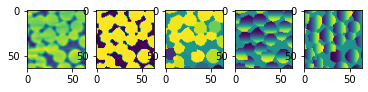

In [5]:
from matplotlib import pyplot as plt

debug_iter = iter(train_ds)
fig, axs = plt.subplots(1,5)
img_b, mask_b = next(debug_iter)
print(img_b.shape, mask_b.shape)
print('Value Range for FG_Mask: (sigmoid)', tf.math.reduce_min(mask_b[...,0]), tf.math.reduce_max(mask_b[...,0]))
print('Value range for flow_mask: (tanh)', tf.math.reduce_min(mask_b[...,1:]), tf.math.reduce_max(mask_b[...,1:]))
axs[0].imshow(img_b[0,32,:,:,0])
axs[1].imshow(mask_b[0,32,:,:,0])
axs[2].imshow(mask_b[0,32,:,:,1])
axs[3].imshow(mask_b[0,32,:,:,2])
axs[4].imshow(mask_b[0,32,:,:,3])

# Train Model

In [6]:
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError(reduction='none')

@tf.function
def flow_loss(flow_true, flow_pred, mask):
    loss = mse(flow_true, flow_pred)
    weight = tf.clip_by_value(mask, 0.01, 1.0) # Weight Gradients that are part of an object more
    loss = tf.math.multiply(loss, weight)
    loss = tf.math.reduce_sum(loss)
    norm = tf.clip_by_value(tf.math.reduce_sum(weight), 1.0, tf.cast(tf.size(mask), tf.float32))
    loss = tf.math.truediv(loss, norm)
    return loss

@tf.function
def get_loss(mask_true, mask_pred):
    loss_bg = mae(mask_true[:,:,:,:,0], mask_pred[:,:,:,:,0]) # TODO ggf. cross_entropy sinnvoller?
    loss_flowx = flow_loss(mask_true[:,:,:,:,1:2], mask_pred[:,:,:,:,1:2], mask_true[:,:,:,:,0])
    loss_flowy = flow_loss(mask_true[:,:,:,:,2:3], mask_pred[:,:,:,:,2:3], mask_true[:,:,:,:,0])
    loss_flowz = flow_loss(mask_true[:,:,:,:,3:4], mask_pred[:,:,:,:,3:4], mask_true[:,:,:,:,0])
    loss_flow = (loss_flowx + loss_flowy + loss_flowz) / 3
    loss = BG_WEIGHT * loss_bg + FLOW_WEIGHT * loss_flow
    return loss

@tf.function
def train_step(img, mask_true):
    with tf.GradientTape() as grad_tape:
        mask_pred = model(img)
        loss = get_loss(mask_true, mask_pred)
    grads = grad_tape.gradient(loss, model.trainable_weights)
    OPT.apply_gradients(zip(grads, model.trainable_weights))
    return loss

@tf.function
def test_step(img, mask_true):
    mask_pred = model(img)
    loss = get_loss(mask_true, mask_pred)
    return loss


In [7]:
#import time
from unet3d import UNet3D
model = UNet3D(feat_channels=FEAT_CHANNELS) # 4 means one output channel for: fg_bg_mask, flowx, flowy,flowz

# this is the right way according to https://www.tensorflow.org/api_docs/python/tf/data/Iterator
train_iter = iter(train_ds)
val_iter = iter(val_ds)
best_loss = float('inf')

for epoch in range(N_EPOCHS):
    #start_time = time.time()
    train_losses = []
    val_losses = []
    for batch in range(N_PER_EPOCH):
        # training
        img, mask_true = next(train_iter)
        loss = train_step(img, mask_true)
        train_losses.append(loss.numpy())
        print(f"\r epoch {epoch+1}/{N_EPOCHS}, batch {batch+1}/{N_PER_EPOCH}", end="")

    # Validation
    for _ in range(N_VAL // BATCH_SIZE):
        img, mask_true = next(val_iter)
        loss = test_step(img, mask_true)
        val_losses.append(loss.numpy())
    print('')
    #print(f'time taken: {time.time() - start_time}')

    # reporting
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)
    print(f"train_loss= {avg_train_loss}, val_loss=  {avg_val_loss}")
    with open(f"models/{MODEL_NAME}/log.csv","a+") as f:
        f.write(f"{epoch}, {avg_train_loss}, {avg_val_loss}\n")
    
    # saving
    if avg_val_loss < best_loss:
        model.save_weights(f'models/{MODEL_NAME}/best-{MODEL_NAME}.hdf5')
        print(f"loss improved from {best_loss} to {avg_val_loss}, best-{MODEL_NAME}.hdf5 saved")
        best_loss = avg_val_loss

2022-06-07 16:51:43.467817: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-06-07 16:51:44.040334: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-07 16:51:44.041466: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-07 16:51:44.041551: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-06-07 16:51:44.042481: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-07 16:51:44.042634: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 epoch 1/100, batch 50/50
train_loss= 0.7397411024570465, val_loss=  0.7463094072957193
loss improved from inf to 0.7463094072957193, best-Cellpose3D-Semanitc.hdf5 saved
 epoch 2/100, batch 50/50
train_loss= 0.38888544380664825, val_loss=  0.6602753746894098
loss improved from 0.7463094072957193 to 0.6602753746894098, best-Cellpose3D-Semanitc.hdf5 saved
 epoch 3/100, batch 50/50
train_loss= 0.24732103377580641, val_loss=  0.6977674999544697
 epoch 4/100, batch 50/50
train_loss= 0.14331970542669295, val_loss=  0.7939083460838564
 epoch 5/100, batch 50/50
train_loss= 0.09821400448679923, val_loss=  0.7895579357301036
 epoch 6/100, batch 50/50
train_loss= 0.07541501596570015, val_loss=  0.8002856219968488
 epoch 7/100, batch 50/50
train_loss= 0.06436785906553269, val_loss=  0.7833944347596937
 epoch 8/100, batch 50/50
train_loss= 0.052719818502664564, val_loss=  0.780178306564208
 epoch 9/100, batch 50/50
train_loss= 0.04621117502450943, val_loss=  0.7931941113164348
 epoch 10/100, batch 

# Evaluation